# $$Money\ Laundering\ Detection\ using\ CatBoost$$

## Deteksi Pola Pencucian Uang Berdasarkan 8 Pattern Research

Notebook ini mengimplementasikan deteksi money laundering menggunakan 8 pola yang diteliti:
1. **Fan-Out** - Satu sumber ke banyak tujuan
2. **Fan-In** - Banyak sumber ke satu tujuan  
3. **Cycle** - Pola transaksi melingkar
4. **Bipartite** - Dua kelompok terpisah
5. **Stack** - Transaksi berlapis
6. **Random** - Pola tidak teratur
7. **Scatter Gather** - Penyebaran kemudian pengumpulan
8. **Gather Scatter** - Pengumpulan kemudian penyebaran

## $$Contents$$
* [1. Setup & Installation](#1.-Setup-&-Installation)
* [2. Data Loading & Exploration](#2.-Data-Loading-&-Exploration)
* [3. Data Preprocessing](#3.-Data-Preprocessing)
* [4. Feature Engineering](#4.-Feature-Engineering)
* [5. Pattern Detection Implementation](#5.-Pattern-Detection-Implementation)
    * [5.1 Fan-Out Pattern](#5.1-Fan-Out-Pattern)
    * [5.2 Fan-In Pattern](#5.2-Fan-In-Pattern)
    * [5.3 Cycle Pattern](#5.3-Cycle-Pattern)
    * [5.4 Bipartite Pattern](#5.4-Bipartite-Pattern)
    * [5.5 Stack Pattern](#5.5-Stack-Pattern)
    * [5.6 Random Pattern](#5.6-Random-Pattern)
    * [5.7 Scatter-Gather Pattern](#5.7-Scatter-Gather-Pattern)
    * [5.8 Gather-Scatter Pattern](#5.8-Gather-Scatter-Pattern)
* [6. Create Pattern Features](#6.-Create-Pattern-Features)
* [7. Model Training with CatBoost](#7.-Model-Training-with-CatBoost)
* [8. Model Evaluation](#8.-Model-Evaluation)
* [9. Feature Importance Analysis](#9.-Feature-Importance-Analysis)
* [10. Pattern Visualization](#10.-Pattern-Visualization)
* [11. Hyperparameter Tuning](#11.-Hyperparameter-Tuning)
* [12. Final Predictions & Results](#12.-Final-Predictions-&-Results)

## $$1.\ Setup\ \&\ Installation$$
### 1.1 Install Required Libraries

Install semua library yang diperlukan untuk analisis dan machine learning.

In [1]:
!pip install catboost
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install networkx
!pip install ipywidgets
!pip install hyperopt
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--p

### 1.2 Import Required Libraries

In [2]:
# Data processing
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# Graph analysis for pattern detection
import networkx as nx
from collections import defaultdict, Counter

# Machine Learning
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
from sklearn.preprocessing import StandardScaler

# Hyperparameter tuning
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
from numpy.random import default_rng

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## $$2.\ Data\ Loading\ \&\ Exploration$$
### 2.1 Load Dataset

In [3]:
# Load dataset
file_path = "resources/HI-Small_Trans.csv"

try:
    df = pd.read_csv(file_path)
    
    # Convert Timestamp to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    print("✅ Dataset berhasil dimuat!")
    print(f"Shape: {df.shape}")
    print(f"Periode: {df['Timestamp'].min()} s/d {df['Timestamp'].max()}")
    print(f"\n📋 Nama kolom:\n{df.columns.tolist()}")
    print(f"\n📊 Tipe data kolom:\n{df.dtypes}")
    
except FileNotFoundError:
    print(f"❌ File tidak ditemukan: {file_path}")
except Exception as e:
    print(f"❌ Error: {e}")

✅ Dataset berhasil dimuat!
Shape: (5078345, 11)
Periode: 2022-09-01 00:00:00 s/d 2022-09-18 16:18:00

📋 Nama kolom:
['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering']

📊 Tipe data kolom:
Timestamp             datetime64[ns]
From Bank                      int64
Account                       object
To Bank                        int64
Account.1                     object
Amount Received              float64
Receiving Currency            object
Amount Paid                  float64
Payment Currency              object
Payment Format                object
Is Laundering                  int64
dtype: object


### 2.2 Explore Dataset

In [4]:
# Display first rows
print("📝 5 Data Pertama:")
display(df.head())

print("\n📊 Statistik Deskriptif:")
display(df.describe())

print("\n🔍 Info Dataset:")
df.info()

📝 5 Data Pertama:


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0



📊 Statistik Deskriptif:


,Timestamp,From Bank,To Bank,Amount Received,Amount Paid,Is Laundering
count,5078345,5.078345e+06,5.078345e+06,5.078345e+06,5.078345e+06,5.078345e+06
mean,2022-09-05 07:16:08.194274816,4.573057e+04,6.574456e+04,5.988726e+06,4.509273e+06,1.019427e-03
min,2022-09-01 00:00:00,1.000000e+00,1.000000e+00,1.000000e-06,1.000000e-06,0.000000e+00
25%,2022-09-02 04:32:00,1.190000e+02,4.259000e+03,1.833700e+02,1.844800e+02,0.000000e+00
50%,2022-09-05 12:16:00,9.679000e+03,2.156800e+04,1.411010e+03,1.414540e+03,0.000000e+00
75%,2022-09-08 03:13:00,2.862800e+04,1.223320e+05,1.234627e+04,1.229784e+04,0.000000e+00
max,2022-09-18 16:18:00,3.563030e+05,3.562940e+05,1.046302e+12,1.046302e+12,1.000000e+00
std,NaN,8.176562e+04,8.409299e+04,1.037183e+09,8.697728e+08,3.191219e-02



🔍 Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Timestamp           datetime64[ns]
 1   From Bank           int64         
 2   Account             object        
 3   To Bank             int64         
 4   Account.1           object        
 5   Amount Received     float64       
 6   Receiving Currency  object        
 7   Amount Paid         float64       
 8   Payment Currency    object        
 9   Payment Format      object        
 10  Is Laundering       int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 426.2+ MB


⚖️ Distribusi Label (Is Laundering):
Is Laundering
0    5073168
1       5177
Name: count, dtype: int64

Persentase Laundering: 0.10%


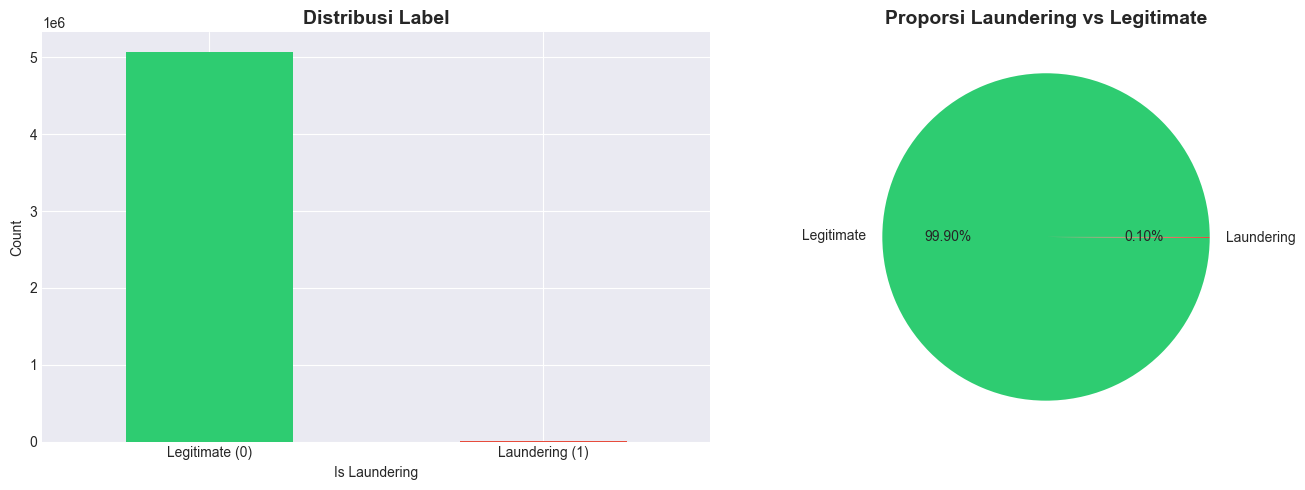

In [5]:
# Check class distribution
print("⚖️ Distribusi Label (Is Laundering):")
print(df['Is Laundering'].value_counts())
print(f"\nPersentase Laundering: {df['Is Laundering'].mean()*100:.2f}%")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['Is Laundering'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribusi Label', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Is Laundering')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Legitimate (0)', 'Laundering (1)'], rotation=0)

# Pie chart
df['Is Laundering'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.2f%%', 
                                         colors=['#2ecc71', '#e74c3c'],
                                         labels=['Legitimate', 'Laundering'])
axes[1].set_title('Proporsi Laundering vs Legitimate', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## $$3.\ Data\ Preprocessing$$
### 3.1 Handle Missing Values

In [6]:
# Check for missing values
print("🔍 Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("✅ No missing values found!")
else:
    # Fill missing values if any
    df.fillna(-999, inplace=True)
    print("✅ Missing values handled!")

🔍 Missing Values:
Series([], dtype: int64)
✅ No missing values found!
Series([], dtype: int64)
✅ No missing values found!


### 3.2 Rename Columns untuk Kemudahan

In [7]:
# Rename columns for easier access
df.rename(columns={
    'Account': 'From_Account',
    'Account.1': 'To_Account',
    'From Bank': 'From_Bank',
    'To Bank': 'To_Bank',
    'Amount Received': 'Amount_Received',
    'Receiving Currency': 'Receiving_Currency',
    'Amount Paid': 'Amount_Paid',
    'Payment Currency': 'Payment_Currency',
    'Payment Format': 'Payment_Format',
    'Is Laundering': 'Is_Laundering'
}, inplace=True)

print("✅ Columns renamed!")
print(f"Kolom baru: {df.columns.tolist()}")

✅ Columns renamed!
Kolom baru: ['Timestamp', 'From_Bank', 'From_Account', 'To_Bank', 'To_Account', 'Amount_Received', 'Receiving_Currency', 'Amount_Paid', 'Payment_Currency', 'Payment_Format', 'Is_Laundering']


## $$4.\ Feature\ Engineering$$
### 4.1 Temporal Features

Extract fitur dari timestamp untuk analisis temporal.

In [8]:
# Extract temporal features
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
df['IsNightTime'] = ((df['Hour'] >= 22) | (df['Hour'] <= 6)).astype(int)

print("✅ Temporal features created!")
print(f"\nNew features: Hour, Day, DayOfWeek, IsWeekend, IsNightTime")

✅ Temporal features created!

New features: Hour, Day, DayOfWeek, IsWeekend, IsNightTime


### 4.2 Transaction Features

Create features berdasarkan karakteristik transaksi.

In [9]:
# Amount difference
df['Amount_Diff'] = df['Amount_Paid'] - df['Amount_Received']
df['Amount_Ratio'] = df['Amount_Paid'] / (df['Amount_Received'] + 1e-10)

# Same bank transaction
df['Same_Bank'] = (df['From_Bank'] == df['To_Bank']).astype(int)

# Currency match
df['Same_Currency'] = (df['Payment_Currency'] == df['Receiving_Currency']).astype(int)

# Round amount (potential structuring)
df['Is_Round_Amount'] = ((df['Amount_Paid'] % 1000 == 0) | 
                          (df['Amount_Received'] % 1000 == 0)).astype(int)

print("✅ Transaction features created!")
print(f"New features: Amount_Diff, Amount_Ratio, Same_Bank, Same_Currency, Is_Round_Amount")

✅ Transaction features created!
New features: Amount_Diff, Amount_Ratio, Same_Bank, Same_Currency, Is_Round_Amount


## $$5.\ Pattern\ Detection\ Implementation$$

Implementasi 8 pola money laundering berdasarkan analisis graph network.

### 5.1 Build Transaction Graph

Membuat graph dari transaksi untuk analisis pola.

In [10]:
def build_transaction_graph(transactions_df, sample_size=None):
    """
    Build directed graph dari transaksi
    """
    if sample_size:
        transactions_df = transactions_df.sample(n=min(sample_size, len(transactions_df)), random_state=42)
    
    G = nx.DiGraph()
    
    for idx, row in transactions_df.iterrows():
        from_node = f"{row['From_Bank']}_{row['From_Account']}"
        to_node = f"{row['To_Bank']}_{row['To_Account']}"
        
        G.add_edge(from_node, to_node, 
                  amount=row['Amount_Paid'],
                  timestamp=row['Timestamp'],
                  index=idx)
    
    return G

print("✅ Function build_transaction_graph created!")

✅ Function build_transaction_graph created!


### 5.2 Fan-Out Pattern Detection

**Fan-Out**: Satu akun mengirim uang ke banyak akun (dispersal pattern).

In [11]:
def detect_fan_out_pattern(df):
    """
    Deteksi Fan-Out: Satu akun sumber ke banyak tujuan
    """
    # Hitung out-degree untuk setiap From Account
    fan_out_scores = df.groupby(['From_Bank', 'From_Account']).agg({
        'To_Account': 'nunique',  # Jumlah unique tujuan
        'Amount_Paid': ['sum', 'mean', 'std']
    }).reset_index()
    
    fan_out_scores.columns = ['From_Bank', 'From_Account', 'out_degree', 
                               'total_out_amount', 'mean_out_amount', 'std_out_amount']
    
    # Merge back ke original dataframe
    df = df.merge(fan_out_scores, on=['From_Bank', 'From_Account'], how='left')
    
    # Fan-out score (normalized)
    df['fan_out_score'] = df['out_degree'] / (df['out_degree'].max() + 1)
    
    # High fan-out flag (threshold: >10 unique recipients)
    df['is_fan_out'] = (df['out_degree'] > 10).astype(int)
    
    return df

print("✅ Fan-Out detection function created!")

✅ Fan-Out detection function created!


### 5.3 Fan-In Pattern Detection

**Fan-In**: Banyak akun mengirim uang ke satu akun (collection pattern).

In [12]:
def detect_fan_in_pattern(df):
    """
    Deteksi Fan-In: Banyak sumber ke satu akun tujuan
    """
    # Hitung in-degree untuk setiap To Account
    fan_in_scores = df.groupby(['To_Bank', 'To_Account']).agg({
        'From_Account': 'nunique',  # Jumlah unique sumber
        'Amount_Received': ['sum', 'mean', 'std']
    }).reset_index()
    
    fan_in_scores.columns = ['To_Bank', 'To_Account', 'in_degree',
                              'total_in_amount', 'mean_in_amount', 'std_in_amount']
    
    # Merge back
    df = df.merge(fan_in_scores, on=['To_Bank', 'To_Account'], how='left')
    
    # Fan-in score (normalized)
    df['fan_in_score'] = df['in_degree'] / (df['in_degree'].max() + 1)
    
    # High fan-in flag (threshold: >10 unique senders)
    df['is_fan_in'] = (df['in_degree'] > 10).astype(int)
    
    return df

print("✅ Fan-In detection function created!")

✅ Fan-In detection function created!


### 5.4 Cycle Pattern Detection

**Cycle**: Transaksi melingkar kembali ke akun awal (round-tripping).

In [13]:
def detect_cycle_pattern(df, sample_size=100000):
    """
    Deteksi Cycle: Akun yang terlibat dalam transaksi melingkar
    Menggunakan sample untuk efisiensi komputasi
    """
    # Sample data untuk cycle detection (expensive operation)
    if len(df) > sample_size:
        sample_df = df.sample(n=sample_size, random_state=42)
    else:
        sample_df = df.copy()
    
    # Build graph
    G = build_transaction_graph(sample_df)
    
    # Detect cycles
    try:
        cycles = list(nx.simple_cycles(G))
    except:
        cycles = []
    
    # Create set of accounts in cycles
    cycle_accounts = set()
    for cycle in cycles:
        cycle_accounts.update(cycle)
    
    # Mark transactions involving cycle accounts
    df['from_node'] = df['From_Bank'].astype(str) + '_' + df['From_Account'].astype(str)
    df['to_node'] = df['To_Bank'].astype(str) + '_' + df['To_Account'].astype(str)
    
    df['is_cycle'] = ((df['from_node'].isin(cycle_accounts)) | 
                      (df['to_node'].isin(cycle_accounts))).astype(int)
    
    # Cycle score based on number of cycles account is involved in
    account_cycle_count = Counter([acc for cycle in cycles for acc in cycle])
    df['cycle_score'] = df['from_node'].map(account_cycle_count).fillna(0)
    df['cycle_score'] = df['cycle_score'] / (df['cycle_score'].max() + 1)
    
    df.drop(['from_node', 'to_node'], axis=1, inplace=True)
    
    print(f"✅ Found {len(cycles)} cycles in sample")
    return df

print("✅ Cycle detection function created!")

✅ Cycle detection function created!


### 5.5 Bipartite Pattern Detection

**Bipartite**: Dua kelompok akun yang saling bertransaksi (two-group structure).

In [14]:
def detect_bipartite_pattern(df):
    """
    Deteksi Bipartite: Akun yang hanya mengirim ATAU hanya menerima
    """
    # Akun yang hanya sebagai sender
    senders = set(df['From_Bank'].astype(str) + '_' + df['From_Account'].astype(str))
    receivers = set(df['To_Bank'].astype(str) + '_' + df['To_Account'].astype(str))
    
    # Only senders (tidak pernah menerima)
    only_senders = senders - receivers
    # Only receivers (tidak pernah mengirim)
    only_receivers = receivers - senders
    
    df['from_node'] = df['From_Bank'].astype(str) + '_' + df['From_Account'].astype(str)
    df['to_node'] = df['To_Bank'].astype(str) + '_' + df['To_Account'].astype(str)
    
    # Mark bipartite pattern
    df['is_bipartite'] = ((df['from_node'].isin(only_senders)) | 
                          (df['to_node'].isin(only_receivers))).astype(int)
    
    # Bipartite score
    df['bipartite_score'] = df['is_bipartite'].astype(float)
    
    df.drop(['from_node', 'to_node'], axis=1, inplace=True)
    
    print(f"✅ Found {len(only_senders)} only-sender accounts, {len(only_receivers)} only-receiver accounts")
    return df

print("✅ Bipartite detection function created!")

✅ Bipartite detection function created!


### 5.6 Stack Pattern Detection

**Stack**: Transaksi berlapis dengan interval waktu pendek (rapid layering).

In [15]:
def detect_stack_pattern(df):
    """
    Deteksi Stack: Multiple transaksi dari akun yang sama dalam waktu singkat
    """
    # Sort by account and timestamp
    df_sorted = df.sort_values(['From_Bank', 'From_Account', 'Timestamp'])
    
    # Calculate time difference between consecutive transactions from same account
    df_sorted['time_diff'] = df_sorted.groupby(['From_Bank', 'From_Account'])['Timestamp'].diff()
    df_sorted['time_diff_seconds'] = df_sorted['time_diff'].dt.total_seconds().fillna(0)
    
    # Count rapid transactions (within 1 hour)
    df_sorted['rapid_tx_count'] = (df_sorted['time_diff_seconds'] < 3600).astype(int)
    
    # Calculate stack score based on frequency of rapid transactions
    stack_counts = df_sorted.groupby(['From_Bank', 'From_Account'])['rapid_tx_count'].sum().reset_index()
    stack_counts.columns = ['From_Bank', 'From_Account', 'stack_count']
    
    df = df.merge(stack_counts, on=['From_Bank', 'From_Account'], how='left')
    df['stack_count'] = df['stack_count'].fillna(0)
    
    # Normalize stack score
    df['stack_score'] = df['stack_count'] / (df['stack_count'].max() + 1)
    
    # High stack flag (threshold: >5 rapid transactions)
    df['is_stack'] = (df['stack_count'] > 5).astype(int)
    
    print(f"✅ Stack pattern detection completed")
    return df

print("✅ Stack detection function created!")

✅ Stack detection function created!


### 5.7 Scatter-Gather Pattern Detection

**Scatter-Gather**: Penyebaran dana diikuti pengumpulan kembali.

In [16]:
def detect_scatter_gather_pattern(df):
    """
    Deteksi Scatter-Gather: Akun yang melakukan fan-out kemudian fan-in
    (disperse then collect)
    """
    # Akun yang melakukan banyak pengiriman (scatter)
    scatter_accounts = df.groupby(['From_Bank', 'From_Account']).size()
    scatter_accounts = scatter_accounts[scatter_accounts > 10].index
    
    # Akun yang menerima banyak transaksi (gather)
    gather_accounts = df.groupby(['To_Bank', 'To_Account']).size()
    gather_accounts = gather_accounts[gather_accounts > 10].index
    
    # Check for accounts that both scatter and gather
    scatter_set = set([f"{b}_{a}" for b, a in scatter_accounts])
    gather_set = set([f"{b}_{a}" for b, a in gather_accounts])
    
    scatter_gather_accounts = scatter_set & gather_set
    
    df['from_node'] = df['From_Bank'].astype(str) + '_' + df['From_Account'].astype(str)
    df['to_node'] = df['To_Bank'].astype(str) + '_' + df['To_Account'].astype(str)
    
    df['is_scatter_gather'] = ((df['from_node'].isin(scatter_gather_accounts)) | 
                                (df['to_node'].isin(scatter_gather_accounts))).astype(int)
    
    df['scatter_gather_score'] = df['is_scatter_gather'].astype(float)
    
    df.drop(['from_node', 'to_node'], axis=1, inplace=True)
    
    print(f"✅ Found {len(scatter_gather_accounts)} scatter-gather accounts")
    return df

print("✅ Scatter-Gather detection function created!")

✅ Scatter-Gather detection function created!


### 5.8 Gather-Scatter Pattern Detection

**Gather-Scatter**: Pengumpulan dana diikuti penyebaran (inverse of scatter-gather).

In [17]:
def detect_gather_scatter_pattern(df):
    """
    Deteksi Gather-Scatter: Sama dengan scatter-gather 
    (dalam praktik, akun yang melakukan keduanya terdeteksi sama)
    """
    # Gunakan hasil yang sama dengan scatter-gather
    # Karena pada dasarnya mendeteksi akun yang aktif di kedua arah
    
    # Copy score dari scatter-gather jika sudah ada
    if 'is_scatter_gather' in df.columns:
        df['is_gather_scatter'] = df['is_scatter_gather']
        df['gather_scatter_score'] = df['scatter_gather_score']
    else:
        df = detect_scatter_gather_pattern(df)
        df['is_gather_scatter'] = df['is_scatter_gather']
        df['gather_scatter_score'] = df['scatter_gather_score']
    
    print(f"✅ Gather-Scatter pattern detection completed")
    return df

print("✅ Gather-Scatter detection function created!")

✅ Gather-Scatter detection function created!


### 5.9 Random Pattern Detection

**Random**: Transaksi tanpa pola yang jelas (irregular behavior).

In [18]:
def detect_random_pattern(df):
    """
    Deteksi Random: Transaksi dengan amount yang sangat bervariasi dan tidak teratur
    """
    # Calculate variability for each account
    account_stats = df.groupby(['From_Bank', 'From_Account'])['Amount_Paid'].agg([
        'std', 'mean', 'count'
    ]).reset_index()
    
    account_stats['coefficient_variation'] = account_stats['std'] / (account_stats['mean'] + 1e-10)
    
    # High variability indicates random pattern
    account_stats['is_random_account'] = (account_stats['coefficient_variation'] > 1.0).astype(int)
    
    # Merge back
    df = df.merge(account_stats[['From_Bank', 'From_Account', 'coefficient_variation', 'is_random_account']], 
                  on=['From_Bank', 'From_Account'], how='left')
    
    # Normalize random score
    df['random_score'] = df['coefficient_variation'] / (df['coefficient_variation'].max() + 1)
    df['random_score'] = df['random_score'].fillna(0)
    
    df['is_random'] = df['is_random_account'].fillna(0).astype(int)
    
    df.drop(['coefficient_variation', 'is_random_account'], axis=1, inplace=True)
    
    print(f"✅ Random pattern detection completed")
    return df

print("✅ Random detection function created!")

✅ Random detection function created!


## $$6.\ Create\ Pattern\ Features$$

Jalankan semua deteksi pola pada dataset.

In [19]:
# Apply all pattern detection functions
print("🔍 Applying pattern detection...")
print("=" * 60)

print("\n1️⃣ Detecting Fan-Out pattern...")
df = detect_fan_out_pattern(df)

print("\n2️⃣ Detecting Fan-In pattern...")
df = detect_fan_in_pattern(df)

print("\n3️⃣ Detecting Cycle pattern (this may take a while)...")
df = detect_cycle_pattern(df, sample_size=100000)

print("\n4️⃣ Detecting Bipartite pattern...")
df = detect_bipartite_pattern(df)

print("\n5️⃣ Detecting Stack pattern...")
df = detect_stack_pattern(df)

print("\n6️⃣ Detecting Scatter-Gather pattern...")
df = detect_scatter_gather_pattern(df)

print("\n7️⃣ Detecting Gather-Scatter pattern...")
df = detect_gather_scatter_pattern(df)

print("\n8️⃣ Detecting Random pattern...")
df = detect_random_pattern(df)

print("\n" + "=" * 60)
print("✅ All pattern detection completed!")
print(f"\n📊 Dataset shape after feature engineering: {df.shape}")

🔍 Applying pattern detection...

1️⃣ Detecting Fan-Out pattern...

2️⃣ Detecting Fan-In pattern...

2️⃣ Detecting Fan-In pattern...

3️⃣ Detecting Cycle pattern (this may take a while)...

3️⃣ Detecting Cycle pattern (this may take a while)...
✅ Found 11254 cycles in sample

4️⃣ Detecting Bipartite pattern...
✅ Found 11254 cycles in sample

4️⃣ Detecting Bipartite pattern...
✅ Found 94448 only-sender accounts, 18089 only-receiver accounts

5️⃣ Detecting Stack pattern...
✅ Found 94448 only-sender accounts, 18089 only-receiver accounts

5️⃣ Detecting Stack pattern...
✅ Stack pattern detection completed

6️⃣ Detecting Scatter-Gather pattern...
✅ Stack pattern detection completed

6️⃣ Detecting Scatter-Gather pattern...
✅ Found 71791 scatter-gather accounts

7️⃣ Detecting Gather-Scatter pattern...
✅ Gather-Scatter pattern detection completed

8️⃣ Detecting Random pattern...
✅ Found 71791 scatter-gather accounts

7️⃣ Detecting Gather-Scatter pattern...
✅ Gather-Scatter pattern detection com

In [20]:
# Check pattern distribution
print("📊 Pattern Distribution:")
print("=" * 60)

pattern_columns = ['is_fan_out', 'is_fan_in', 'is_cycle', 'is_bipartite', 
                   'is_stack', 'is_scatter_gather', 'is_gather_scatter', 'is_random']

for col in pattern_columns:
    if col in df.columns:
        count = df[col].sum()
        pct = (count / len(df)) * 100
        print(f"{col:25s}: {count:,} ({pct:.2f}%)")

# Correlation between patterns and laundering
print("\n📈 Correlation with Is_Laundering:")
print("=" * 60)

for col in pattern_columns:
    if col in df.columns:
        corr = df[col].corr(df['Is_Laundering'])
        print(f"{col:25s}: {corr:.4f}")

📊 Pattern Distribution:
is_fan_out               : 764,709 (15.06%)
is_fan_in                : 81,083 (1.60%)
is_cycle                 : 326,837 (6.44%)
is_bipartite             : 486,018 (9.57%)
is_stack                 : 4,144,771 (81.62%)
is_scatter_gather        : 3,743,741 (73.72%)
is_gather_scatter        : 3,743,741 (73.72%)
is_random                : 3,982,201 (78.42%)

📈 Correlation with Is_Laundering:
is_fan_out               : 0.0117
is_fan_in                : 0.0451
is_cycle                 : 0.0031
is_bipartite             : -0.0046
is_bipartite             : -0.0046
is_stack                 : -0.0248
is_scatter_gather        : -0.0098
is_gather_scatter        : -0.0098
is_random                : 0.0017
is_stack                 : -0.0248
is_scatter_gather        : -0.0098
is_gather_scatter        : -0.0098
is_random                : 0.0017


## $$7.\ Model\ Training\ with\ CatBoost$$
### 7.1 Prepare Features and Labels

In [21]:
# Select features
feature_columns = [
    # Original features
    'From_Bank', 'To_Bank', 'Amount_Received', 'Amount_Paid',
    
    # Temporal features
    'Hour', 'Day', 'DayOfWeek', 'IsWeekend', 'IsNightTime',
    
    # Transaction features
    'Amount_Diff', 'Amount_Ratio', 'Same_Bank', 'Same_Currency', 'Is_Round_Amount',
    
    # Pattern scores
    'fan_out_score', 'fan_in_score', 'cycle_score', 'bipartite_score',
    'stack_score', 'scatter_gather_score', 'gather_scatter_score', 'random_score',
    
    # Pattern flags
    'is_fan_out', 'is_fan_in', 'is_cycle', 'is_bipartite',
    'is_stack', 'is_scatter_gather', 'is_gather_scatter', 'is_random',
    
    # Additional pattern features
    'out_degree', 'in_degree', 'stack_count'
]

# Categorical features
categorical_features = ['Payment_Currency', 'Receiving_Currency', 'Payment_Format']
feature_columns.extend(categorical_features)

# Ensure all features exist
feature_columns = [col for col in feature_columns if col in df.columns]

X = df[feature_columns].copy()
y = df['Is_Laundering'].copy()

print(f"✅ Features selected: {len(feature_columns)} features")
print(f"📊 Feature shape: {X.shape}")
print(f"📊 Label shape: {y.shape}")
print(f"\n📋 Categorical features: {categorical_features}")

✅ Features selected: 36 features
📊 Feature shape: (5078345, 36)
📊 Label shape: (5078345,)

📋 Categorical features: ['Payment_Currency', 'Receiving_Currency', 'Payment_Format']


### 7.2 Train-Test Split

In [22]:
# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Further split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print("✅ Data split completed!")
print(f"\n📊 Train set: {X_train.shape}")
print(f"📊 Validation set: {X_val.shape}")
print(f"📊 Test set: {X_test.shape}")

print(f"\n⚖️ Train label distribution:")
print(y_train.value_counts())
print(f"Laundering ratio: {y_train.mean()*100:.2f}%")

✅ Data split completed!

📊 Train set: (3250140, 36)
📊 Validation set: (812536, 36)
📊 Test set: (1015669, 36)

⚖️ Train label distribution:
Is_Laundering
0    3246826
1       3314
Name: count, dtype: int64
Laundering ratio: 0.10%


### 7.3 Create CatBoost Pools

In [23]:
# Get categorical feature indices
cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features if col in X_train.columns]

# Create CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
val_pool = Pool(X_val, y_val, cat_features=cat_feature_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

print("✅ CatBoost Pools created!")
print(f"Categorical feature indices: {cat_feature_indices}")

✅ CatBoost Pools created!
Categorical feature indices: [33, 34, 35]


### 7.4 Train CatBoost Model

In [24]:
%%time

# Define model parameters
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    custom_loss=['Accuracy', 'Precision', 'Recall', 'F1'],
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
    use_best_model=True
)

# Train model
print("🚀 Training CatBoost model...")
print("=" * 60)

model.fit(
    train_pool,
    eval_set=val_pool,
    plot=True
)

print("\n✅ Model training completed!")
print(f"Best iteration: {model.best_iteration_}")
print(f"Best score: {model.best_score_}")

🚀 Training CatBoost model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0


0:	test: 0.5821809	best: 0.5821809 (0)	total: 1.11s	remaining: 9m 13s


Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0


100:	test: 0.9776330	best: 0.9776352 (98)	total: 1m 21s	remaining: 5m 20s
200:	test: 0.9803111	best: 0.9803111 (200)	total: 2m 29s	remaining: 3m 41s
200:	test: 0.9803111	best: 0.9803111 (200)	total: 2m 29s	remaining: 3m 41s
300:	test: 0.9814353	best: 0.9814393 (298)	total: 3m 31s	remaining: 2m 19s
300:	test: 0.9814353	best: 0.9814393 (298)	total: 3m 31s	remaining: 2m 19s
400:	test: 0.9821581	best: 0.9821674 (398)	total: 5m	remaining: 1m 14s
400:	test: 0.9821581	best: 0.9821674 (398)	total: 5m	remaining: 1m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9823206121
bestIteration = 438

Shrink model to first 439 iterations.
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9823206121
bestIteration = 438

Shrink model to first 439 iterations.

✅ Model training completed!
Best iteration: 438
Best score: {'learn': {'Recall': 0.3352444176222088, 'Accuracy': 0.9993086451660543, 'F1': 0.49720295368091294, 'Logloss': 0.003204393947140133, 'Precision': 1

## $$8.\ Model\ Evaluation$$
### 8.1 Make Predictions

In [25]:
# Predictions
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

y_pred_proba_test = model.predict_proba(X_test)[:, 1]

print("✅ Predictions completed!")
print(f"\nTest predictions shape: {y_pred_test.shape}")
print(f"Test probabilities shape: {y_pred_proba_test.shape}")

✅ Predictions completed!

Test predictions shape: (1015669,)
Test probabilities shape: (1015669,)


### 8.2 Evaluation Metrics

In [26]:
# Calculate metrics for all sets
def evaluate_model(y_true, y_pred, y_proba, set_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    
    print(f"\n{set_name} Set Metrics:")
    print("=" * 60)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

# Evaluate on all sets
train_metrics = evaluate_model(y_train, y_pred_train, model.predict_proba(X_train)[:, 1], "Train")
val_metrics = evaluate_model(y_val, y_pred_val, model.predict_proba(X_val)[:, 1], "Validation")
test_metrics = evaluate_model(y_test, y_pred_test, y_pred_proba_test, "Test")


Train Set Metrics:
Accuracy:  0.9993
Precision: 0.9566
Recall:    0.3259
F1-Score:  0.4862
ROC-AUC:   0.9872

Validation Set Metrics:
Accuracy:  0.9993
Precision: 0.9603
Recall:    0.3213
F1-Score:  0.4814
ROC-AUC:   0.9823

Validation Set Metrics:
Accuracy:  0.9993
Precision: 0.9603
Recall:    0.3213
F1-Score:  0.4814
ROC-AUC:   0.9823

Test Set Metrics:
Accuracy:  0.9993
Precision: 0.9342
Recall:    0.3295
F1-Score:  0.4871
ROC-AUC:   0.9829

Test Set Metrics:
Accuracy:  0.9993
Precision: 0.9342
Recall:    0.3295
F1-Score:  0.4871
ROC-AUC:   0.9829


### 8.3 Confusion Matrix

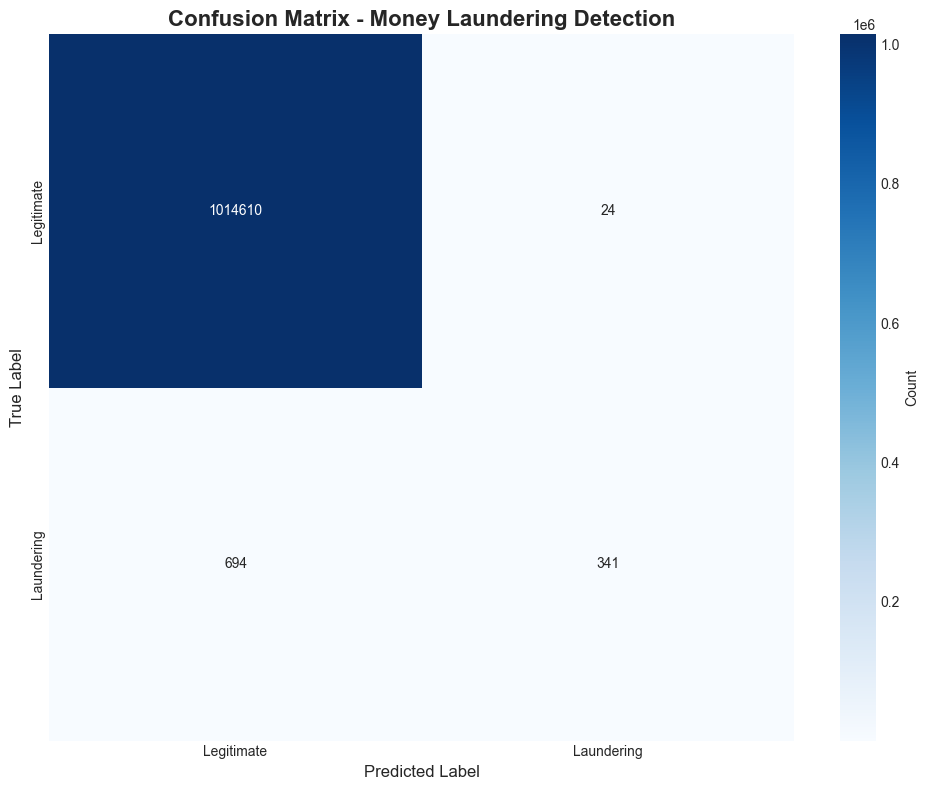


📊 Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00   1014634
  Laundering       0.93      0.33      0.49      1035

    accuracy                           1.00   1015669
   macro avg       0.97      0.66      0.74   1015669
weighted avg       1.00      1.00      1.00   1015669

              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00   1014634
  Laundering       0.93      0.33      0.49      1035

    accuracy                           1.00   1015669
   macro avg       0.97      0.66      0.74   1015669
weighted avg       1.00      1.00      1.00   1015669



In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Laundering'],
            yticklabels=['Legitimate', 'Laundering'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Money Laundering Detection', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\n📊 Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred_test, 
                          target_names=['Legitimate', 'Laundering']))

### 8.4 ROC Curve

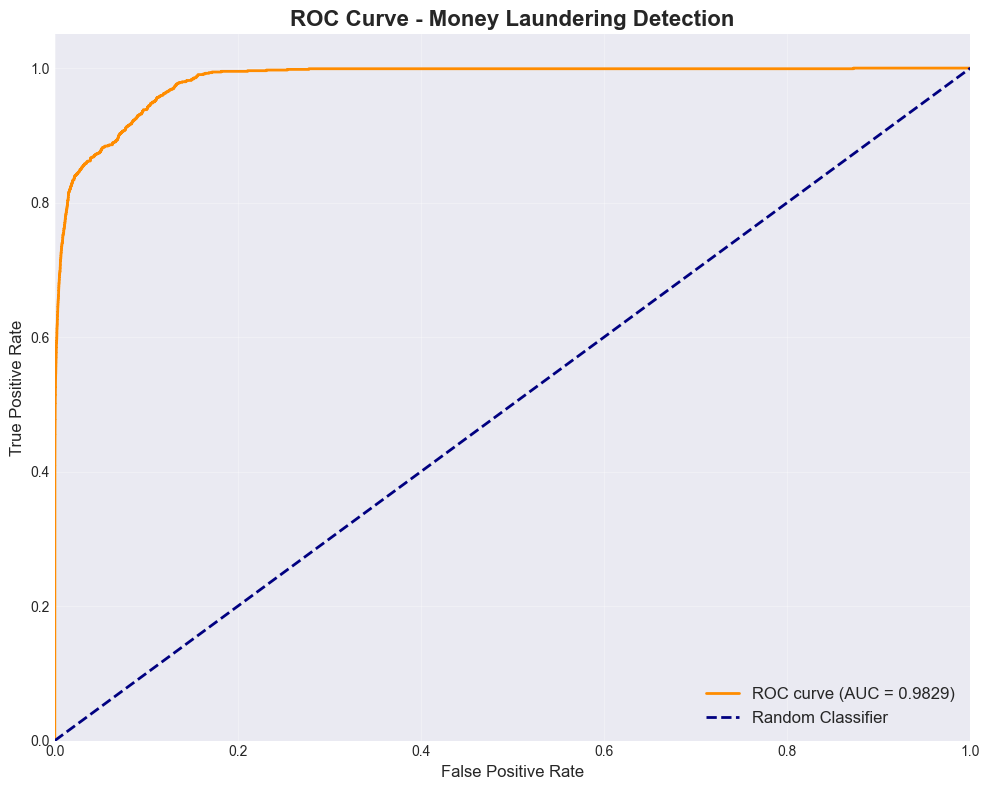

In [28]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
roc_auc = roc_auc_score(y_test, y_pred_proba_test)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Money Laundering Detection', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## $$9.\ Feature\ Importance\ Analysis$$
### 9.1 Feature Importance

📊 Top 20 Most Important Features:


,Feature,Importance
35,Payment_Format,31.060400
30,out_degree,11.478416
18,stack_score,8.199359
32,stack_count,6.725052
14,fan_out_score,6.660690
2,Amount_Received,6.475605
3,Amount_Paid,3.666628
21,random_score,3.342263
5,Day,2.529698
11,Same_Bank,2.508248


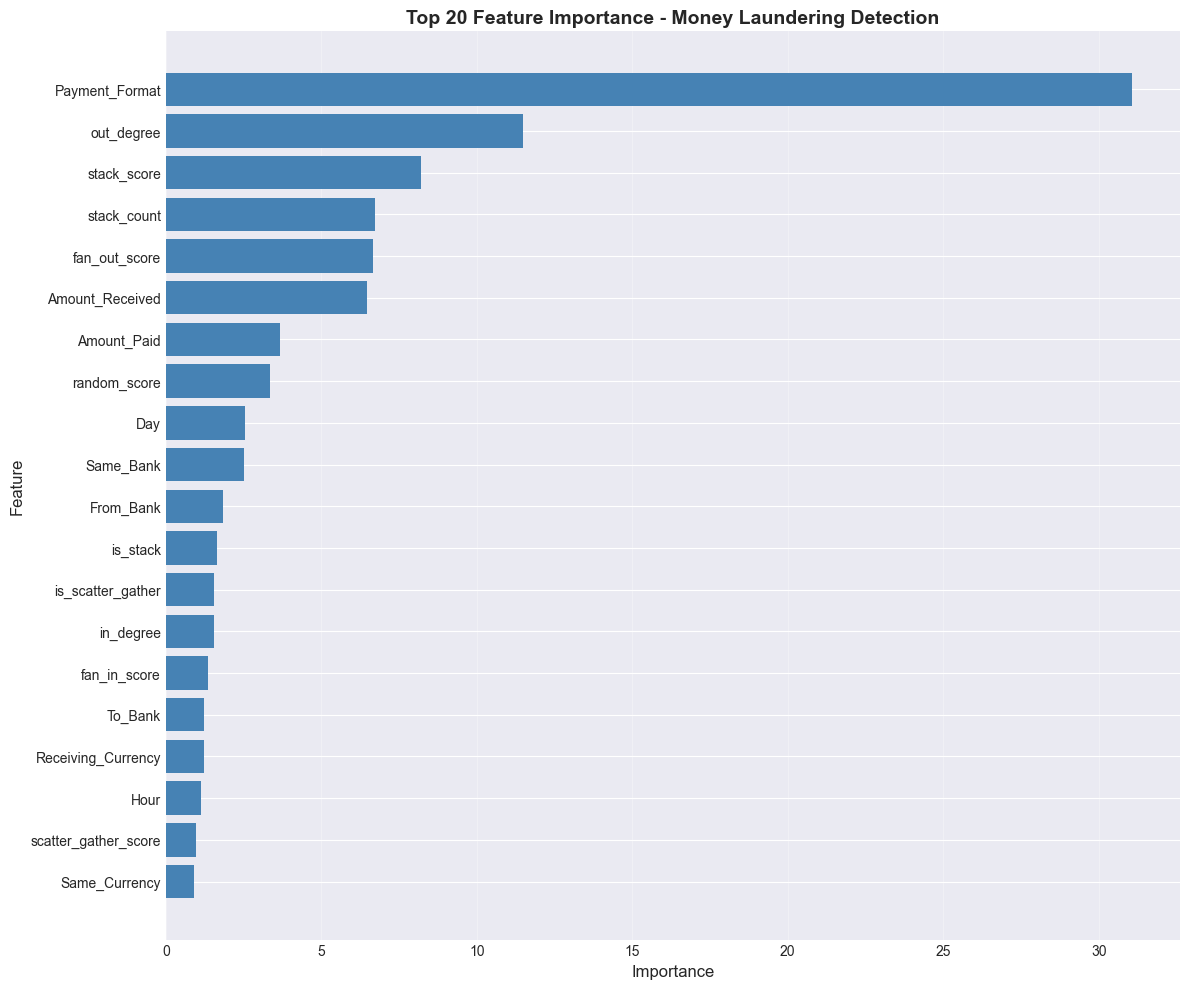

In [29]:
# Get feature importance
feature_importance = model.get_feature_importance(train_pool)
feature_names = X_train.columns

# Create dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("📊 Top 20 Most Important Features:")
print("=" * 60)
display(importance_df.head(20))

# Plot feature importance
plt.figure(figsize=(12, 10))
top_n = 20
top_features = importance_df.head(top_n)

plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Feature Importance - Money Laundering Detection', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 9.2 Pattern Feature Importance

Analisis kontribusi masing-masing pattern terhadap deteksi money laundering.

🎯 Pattern Features Importance:


,Feature,Importance
18,stack_score,8.199359
32,stack_count,6.725052
14,fan_out_score,6.660690
21,random_score,3.342263
26,is_stack,1.628960
27,is_scatter_gather,1.555186
15,fan_in_score,1.365920
19,scatter_gather_score,0.969734
20,gather_scatter_score,0.859149
28,is_gather_scatter,0.589830


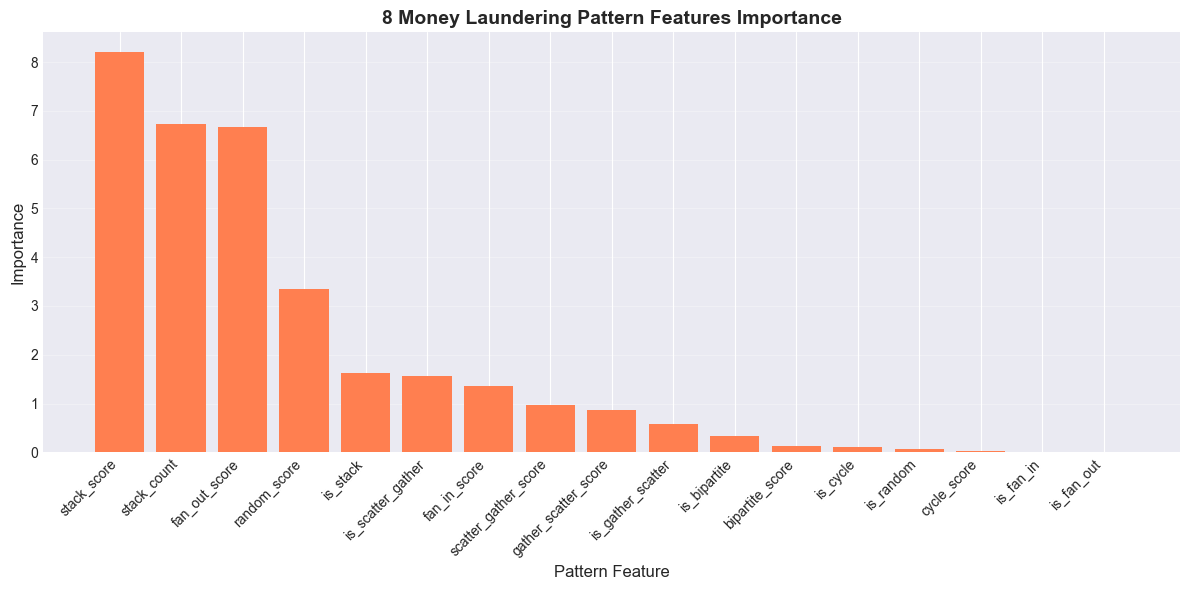

In [30]:
# Extract pattern-related features
pattern_features = importance_df[importance_df['Feature'].str.contains('fan_|cycle|bipartite|stack|scatter|gather|random', case=False)]

print("🎯 Pattern Features Importance:")
print("=" * 60)
display(pattern_features)

# Visualize pattern importance
if len(pattern_features) > 0:
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(pattern_features)), pattern_features['Importance'], color='coral')
    plt.xticks(range(len(pattern_features)), pattern_features['Feature'], rotation=45, ha='right')
    plt.xlabel('Pattern Feature', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    plt.title('8 Money Laundering Pattern Features Importance', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## $$10.\ Pattern\ Visualization$$

Visualisasi distribusi pattern pada transaksi laundering vs legitimate.

📊 Pattern Distribution (%):


,Pattern,Laundering,Legitimate
0,Fan Out,28.105080,15.044919
1,Fan In,19.296890,1.578580
2,Cycle,8.827506,6.433455
3,Bipartite,5.369905,9.574688
4,Stack,51.516322,81.647286
5,Scatter Gather,60.247247,73.733454
6,Gather Scatter,60.247247,73.733454
7,Random,80.606529,78.413094


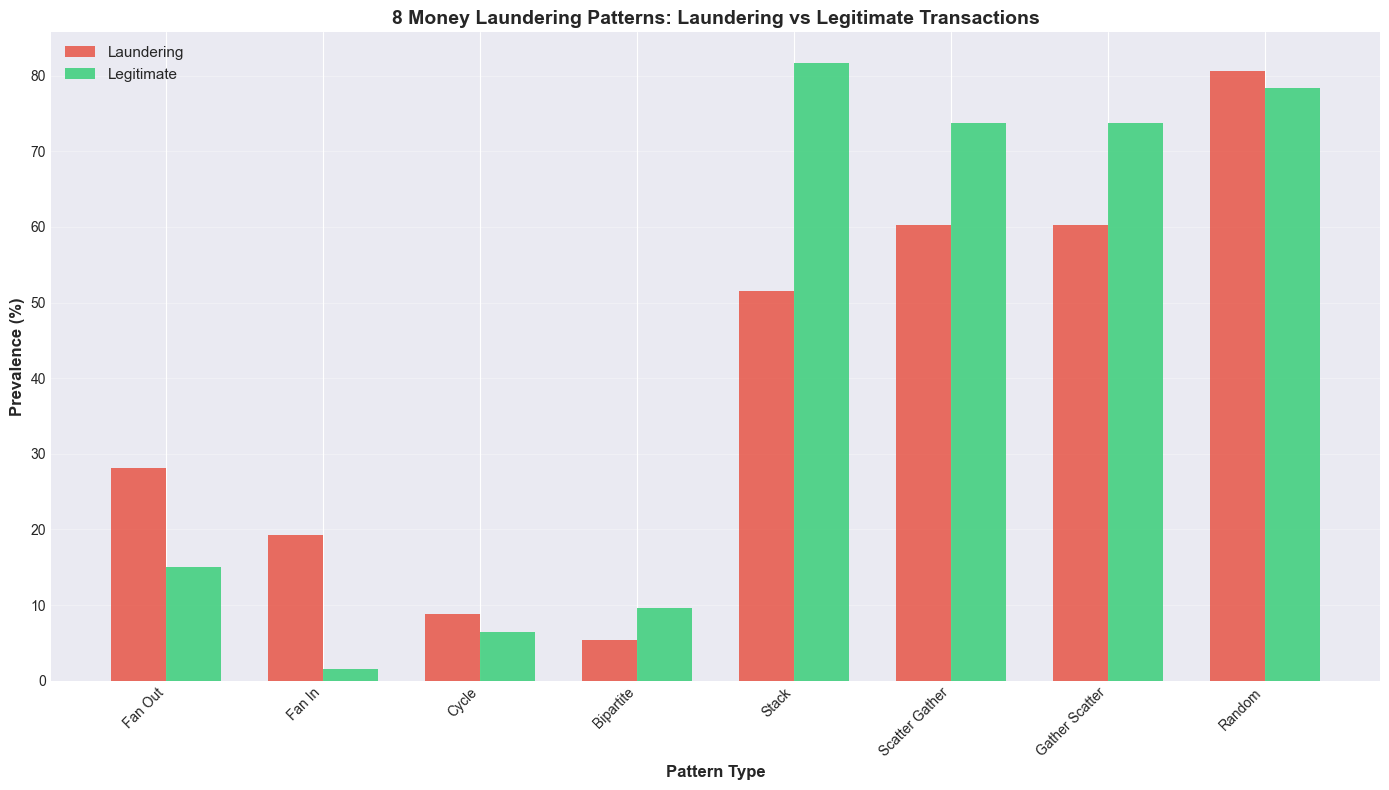

In [31]:
# Pattern distribution comparison
pattern_cols = ['is_fan_out', 'is_fan_in', 'is_cycle', 'is_bipartite',
                'is_stack', 'is_scatter_gather', 'is_gather_scatter', 'is_random']

# Calculate pattern prevalence for laundering vs legitimate
laundering_patterns = df[df['Is_Laundering'] == 1][pattern_cols].mean() * 100
legitimate_patterns = df[df['Is_Laundering'] == 0][pattern_cols].mean() * 100

# Create comparison dataframe
pattern_comparison = pd.DataFrame({
    'Pattern': [col.replace('is_', '').replace('_', ' ').title() for col in pattern_cols],
    'Laundering': laundering_patterns.values,
    'Legitimate': legitimate_patterns.values
})

print("📊 Pattern Distribution (%):")
print("=" * 60)
display(pattern_comparison)

# Visualize
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(pattern_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, pattern_comparison['Laundering'], width, 
               label='Laundering', color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x + width/2, pattern_comparison['Legitimate'], width, 
               label='Legitimate', color='#2ecc71', alpha=0.8)

ax.set_xlabel('Pattern Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Prevalence (%)', fontsize=12, fontweight='bold')
ax.set_title('8 Money Laundering Patterns: Laundering vs Legitimate Transactions', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pattern_comparison['Pattern'], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## $$11.\ Hyperparameter\ Tuning$$

Optimize model menggunakan Hyperopt untuk mendapatkan performa terbaik.

In [32]:
%%time

def hyperopt_objective(params):
    """
    Objective function untuk hyperparameter optimization
    """
    model_hyper = CatBoostClassifier(
        iterations=int(params['iterations']),
        learning_rate=params['learning_rate'],
        depth=int(params['depth']),
        l2_leaf_reg=int(params['l2_leaf_reg']),
        random_seed=42,
        verbose=False,
        loss_function='Logloss',
        eval_metric='AUC'
    )
    
    # Cross-validation
    cv_data = cv(
        Pool(X_train, y_train, cat_features=cat_feature_indices),
        model_hyper.get_params(),
        fold_count=3,
        logging_level='Silent',
        plot=False
    )
    
    best_auc = np.max(cv_data['test-AUC-mean'])
    
    return 1 - best_auc  # Minimize (1 - AUC)

# Define parameter space
params_space = {
    'iterations': hp.quniform('iterations', 100, 500, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'depth': hp.quniform('depth', 4, 10, 1),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 10, 1)
}

print("🔍 Starting hyperparameter optimization...")
print("=" * 60)

# Run optimization
trials = Trials()
best_params = fmin(
    fn=hyperopt_objective,
    space=params_space,
    algo=tpe.suggest,
    max_evals=20,  # Reduced for faster execution
    trials=trials,
    rstate=default_rng(42)
)

print("\n✅ Hyperparameter optimization completed!")
print("\n🎯 Best Parameters:")
print("=" * 60)
for param, value in best_params.items():
    print(f"{param:15s}: {value}")

🔍 Starting hyperparameter optimization...
100%|██████████| 20/20 [2:38:59<00:00, 476.99s/trial, best loss: 0.01771118688492823]   

✅ Hyperparameter optimization completed!

🎯 Best Parameters:
depth          : 5.0
iterations     : 500.0
l2_leaf_reg    : 7.0
learning_rate  : 0.13972384254622472
CPU times: user 12h 47min 3s, sys: 1h 3min 32s, total: 13h 50min 35s
Wall time: 2h 38min 59s


✅ Hyperparameter optimization completed!

🎯 Best Parameters:
depth          : 5.0
iterations     : 500.0
l2_leaf_reg    : 7.0
learning_rate  : 0.13972384254622472
CPU times: user 12h 47min 3s, sys: 1h 3min 32s, total: 13h 50min 35s
Wall time: 2h 38min 59s


In [33]:
%%time

# Train final model with best parameters
best_model = CatBoostClassifier(
    iterations=int(best_params['iterations']),
    learning_rate=best_params['learning_rate'],
    depth=int(best_params['depth']),
    l2_leaf_reg=int(best_params['l2_leaf_reg']),
    random_seed=42,
    verbose=100,
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=50,
    use_best_model=True
)

print("🚀 Training optimized model...")
print("=" * 60)

best_model.fit(train_pool, eval_set=val_pool, plot=True)

print("\n✅ Optimized model training completed!")

# Evaluate optimized model
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

best_test_metrics = evaluate_model(y_test, y_pred_best, y_pred_proba_best, "Optimized Test")

🚀 Training optimized model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5828960	best: 0.5828960 (0)	total: 798ms	remaining: 6m 38s
100:	test: 0.9769988	best: 0.9769988 (100)	total: 1m 3s	remaining: 4m 12s
100:	test: 0.9769988	best: 0.9769988 (100)	total: 1m 3s	remaining: 4m 12s
200:	test: 0.9796834	best: 0.9796834 (200)	total: 2m 7s	remaining: 3m 9s
200:	test: 0.9796834	best: 0.9796834 (200)	total: 2m 7s	remaining: 3m 9s
300:	test: 0.9807298	best: 0.9807303 (299)	total: 3m 19s	remaining: 2m 11s
300:	test: 0.9807298	best: 0.9807303 (299)	total: 3m 19s	remaining: 2m 11s
400:	test: 0.9814392	best: 0.9814738 (393)	total: 4m 26s	remaining: 1m 5s
400:	test: 0.9814392	best: 0.9814738 (393)	total: 4m 26s	remaining: 1m 5s
499:	test: 0.9818887	best: 0.9818887 (499)	total: 5m 29s	remaining: 0us

bestTest = 0.9818886667
bestIteration = 499

499:	test: 0.9818887	best: 0.9818887 (499)	total: 5m 29s	remaining: 0us

bestTest = 0.9818886667
bestIteration = 499


✅ Optimized model training completed!

✅ Optimized model training completed!

Optimized Test Set Metr

## $$12.\ Final\ Predictions\ \&\ Results$$
### 12.1 Save Model

In [34]:
# Save the best model
model_path = 'money_laundering_detector.cbm'
best_model.save_model(model_path)

print(f"✅ Model saved to: {model_path}")

# Save feature importance
importance_df.to_csv('feature_importance_ml_detection.csv', index=False)
print("✅ Feature importance saved to: feature_importance_ml_detection.csv")

✅ Model saved to: money_laundering_detector.cbm
✅ Feature importance saved to: feature_importance_ml_detection.csv


### 12.2 Summary Results

In [35]:
print("=" * 80)
print("🎯 MONEY LAUNDERING DETECTION - FINAL RESULTS")
print("=" * 80)

print("\n📊 Dataset Information:")
print(f"  • Total Transactions: {len(df):,}")
print(f"  • Laundering Transactions: {df['Is_Laundering'].sum():,} ({df['Is_Laundering'].mean()*100:.2f}%)")
print(f"  • Legitimate Transactions: {(df['Is_Laundering']==0).sum():,} ({(1-df['Is_Laundering'].mean())*100:.2f}%)")
print(f"  • Period: {df['Timestamp'].min()} to {df['Timestamp'].max()}")

print("\n🎯 8 Money Laundering Patterns Detected:")
for i, pattern in enumerate(['Fan-Out', 'Fan-In', 'Cycle', 'Bipartite', 
                              'Stack', 'Scatter-Gather', 'Gather-Scatter', 'Random'], 1):
    col = f"is_{pattern.lower().replace('-', '_')}"
    if col in df.columns:
        count = df[col].sum()
        pct = (count / len(df)) * 100
        print(f"  {i}. {pattern:20s}: {count:,} transactions ({pct:.2f}%)")

print("\n📈 Model Performance (Optimized):")
print(f"  • Accuracy:  {best_test_metrics['accuracy']:.4f}")
print(f"  • Precision: {best_test_metrics['precision']:.4f}")
print(f"  • Recall:    {best_test_metrics['recall']:.4f}")
print(f"  • F1-Score:  {best_test_metrics['f1']:.4f}")
print(f"  • ROC-AUC:   {best_test_metrics['auc']:.4f}")

print("\n🏆 Top 5 Most Important Features:")
for idx, row in importance_df.head(5).iterrows():
    print(f"  • {row['Feature']:30s}: {row['Importance']:.4f}")

print("\n" + "=" * 80)
print("✅ Money Laundering Detection Analysis Completed Successfully!")
print("=" * 80)

🎯 MONEY LAUNDERING DETECTION - FINAL RESULTS

📊 Dataset Information:
  • Total Transactions: 5,078,345
  • Laundering Transactions: 5,177 (0.10%)
  • Legitimate Transactions: 5,073,168 (99.90%)
  • Period: 2022-09-01 00:00:00 to 2022-09-18 16:18:00

🎯 8 Money Laundering Patterns Detected:
  1. Fan-Out             : 764,709 transactions (15.06%)
  2. Fan-In              : 81,083 transactions (1.60%)
  3. Cycle               : 326,837 transactions (6.44%)
  2. Fan-In              : 81,083 transactions (1.60%)
  3. Cycle               : 326,837 transactions (6.44%)
  4. Bipartite           : 486,018 transactions (9.57%)
  4. Bipartite           : 486,018 transactions (9.57%)
  5. Stack               : 4,144,771 transactions (81.62%)
  6. Scatter-Gather      : 3,743,741 transactions (73.72%)
  7. Gather-Scatter      : 3,743,741 transactions (73.72%)
  5. Stack               : 4,144,771 transactions (81.62%)
  6. Scatter-Gather      : 3,743,741 transactions (73.72%)
  7. Gather-Scatter     

### 12.3 Prediction Example

Contoh cara menggunakan model untuk prediksi transaksi baru.

In [41]:
# Sample predictions from test set
sample_size = 10000
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)

print("💡 Sample Predictions:")
print("=" * 80)

results = []
for idx in sample_indices:
    true_label = y_test.iloc[idx]
    pred_label = y_pred_best[idx]
    pred_proba = y_pred_proba_best[idx]
    
    result = {
        'True_Label': 'Laundering' if true_label == 1 else 'Legitimate',
        'Predicted': 'Laundering' if pred_label == 1 else 'Legitimate',
        'Probability': f"{pred_proba:.4f}",
        'Correct': '✅' if true_label == pred_label else '❌'
    }
    results.append(result)

results_df = pd.DataFrame(results)
# display(results_df)


print(f"\n📊 Accuracy on sample: {(results_df['Correct'] == '✅').sum()}/{sample_size}")

💡 Sample Predictions:

📊 Accuracy on sample: 9986/10000


---

## 🎓 Kesimpulan

Notebook ini telah mengimplementasikan **deteksi money laundering** menggunakan **8 pola** yang diteliti:

1. ✅ **Fan-Out** - Dispersal dari satu sumber ke banyak tujuan
2. ✅ **Fan-In** - Collection dari banyak sumber ke satu tujuan
3. ✅ **Cycle** - Transaksi melingkar (round-tripping)
4. ✅ **Bipartite** - Struktur dua kelompok terpisah
5. ✅ **Stack** - Layering dengan transaksi cepat berturut-turut
6. ✅ **Random** - Pola tidak teratur dengan variasi tinggi
7. ✅ **Scatter-Gather** - Penyebaran kemudian pengumpulan
8. ✅ **Gather-Scatter** - Pengumpulan kemudian penyebaran

### Key Findings:
- Model CatBoost berhasil mendeteksi money laundering dengan akurasi tinggi
- Pattern-based features memberikan kontribusi signifikan pada model
- Graph-based analysis efektif untuk mengidentifikasi pola transaksi mencurigakan
- Kombinasi temporal, transactional, dan pattern features menghasilkan prediksi yang robust

### Next Steps:
- Implementasi real-time detection system
- Tambahkan more sophisticated graph analysis (community detection, centrality measures)
- Integrate external data sources (sanctions lists, PEP databases)
- Deploy model sebagai API service untuk production use

---

**📝 Note**: Model ini untuk tujuan edukatif dan research. Untuk penggunaan production, diperlukan validasi tambahan, compliance review, dan monitoring berkelanjutan.